### ***Aulas 3 - 4 - 5 - Planejamento de Sistemas Elétricos***

## PPEE - UFJF

Estas são as aulas 3, 4 e 5 da disciplina de Planejamento de Sistemas Elétricos do PPEE-UFJF.

O seu objetivo é apresentar uma implementação em Python da Técnica de Programação Dinâmica Determinística (PDD) aplicada ao Planejamento da Operação de Sistemas Hidrotérmicos (Aula 4).

É apresentada tambéém uma formulação para a resolução de um problema de despacho hidrotérmico determinístico através de um Programa de Programação Linear Único, ou seja, contemplando todos os estágios (Aula 3).

Finalmente, é inserido o algoritmo da PDDD (Prgramação Dinâmica Dual Determinística), apresentado na aula 5.

Esta é uma abordagem determinística pois se pressupõe que as vazões às UHEs são conhecidas para todos os estágios ou períodos de planejamento.


## Definição dos Dados do Problema

Usinas Hidrelétricas, termelétricas e dados gerais do sistema

In [0]:
lista_uhe = []

usina = {
    "Nome": "UHE DO MARCATO", # Nome da Usina
    "Vmax": 100.,            # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "VI": 65.,
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [ 23, 16],
            [ 19, 14],
            [ 15, 11]
    ]
}

lista_uhe.append(usina)

#
# Retirar os comentários abaixo para considerar 2 UHEs
#
#usina = {
#    "Nome": "UHE DO VASCAO",
#    "Vmax": 200.,
#    "Vmin": 40.,
#    "VI": 80,
#    "Prod": 0.85,
#    "Engol": 100.,
#    "Afl": [ 
#            [ 46, 32],
#            [ 38, 28],
#            [ 30, 22]
#    ]
#}
#lista_uhe.append(usina)

usina = {
    "Nome": "GT_1",     # Nome da Usina Térmica 1
    "Capac": 15.,       # Capacidade Máxima de Geração MWMed
    "Custo": 10.        # Custo de Operação $/MWMed
}

lista_ute = []

lista_ute.append(usina)

usina = {
    "Nome": "GT_2",     # Nome da Usina Térmica 2
    "Capac": 10.,       # Capacidade Máxima de Geração MWmed
    "Custo": 25.        # Custo de Operação $/MWMed
}

lista_ute.append(usina)

#
# d_gerais para o caso 1 UHE
#
d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    "Carga": [ 50, 50., 50],  # Lista com carga a ser atendida por estágio
    "Nr_Disc": 3,            # Número de Discretizações
    "Nr_Est": 3,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}

#
# d_gerais para o caso 2 UHE (Comentar o bloco acima e descomentar o bloco abaixo)
#
#d_gerais = {
#    "CDef": 500.,
#    "Carga": [ 100, 100., 100],
#    "Nr_Disc": 5,
#    "Nr_Est": 3,
#    "Nr_Cen": 2
#}

#
# Cria dicionário de dados com todas as informações do sistema em estudo
#
sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


## Modelo de Otimização

Criação de uma Função para o Despacho Hidrotérmico

$Min \hspace{0.5cm} C_1 \cdot gt_1 + C_2 \cdot gt_2 + CDEF \cdot def + 0.01 \cdot vvert + \alpha$

sujeito a:

$ VF = VI + AFL - vtur - vvert $ (Equação de Balanço Hídrico)

$ \rho \cdot vtur + gt_1 + gt_2 + def = CARGA $ (Equação de Atendimento à Demanda)

$ 0 \le vtur \le 60 $

$ 0 \le vvert \le \infty $

$ 0 \le gt_1 \le 15 $

$ 0 \le gt_2 \le 10 $

$ 0 \le def \le \infty $

Na abordagem PDD são resolvidos diversos problemas de otimização de um único estágio com a formulação descrita acima. A função ***despacho_pdd*** tem o objetivo de implementar um PPL (Problema de Programação Linear) para resolver esses problemas de estágio único.


In [0]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op
import numpy as np

#
# Cria função de despacho hidrotérmico
#

def despacho_pdd(sistema, VI, VF, AFL, custofuturo, iest, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão
  #

  vt = variable(Num_UHE, "Volume Turbinado na Usina")
  vv = variable(Num_UHE, "Volume Vertido na Usina")
  gt = variable(Num_UTE, "Geração na Usina Térmica")
  deficit = variable(1, "Déficit de Energia no Sistema")

  # Construção da Função Objetivo

  fob = 0

  for i, iusi in enumerate(sistema["UTE"]):
    fob += iusi['Custo']*gt[i]

  fob += sistema["DGer"]["CDef"]*deficit[0]

  for i, iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

  # Definição das Restrições

  restricoes = []

  # Balanço Hídrico

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append( float(VF[i]) == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

  # Atendimento à Demanda

  AD = 0

  for i,usi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

  for i,usi in enumerate(sistema["UTE"]):
    AD += gt[i]

  AD += deficit[0]

  restricoes.append( AD == sistema["DGer"]["Carga"][iest])

  # Restricoes Canalização

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vt[i] >= 0)
    restricoes.append(vt[i] <= iusi["Engol"])
    restricoes.append(vv[i] >= 0)

  for i, iusi in enumerate(sistema["UTE"]):
    restricoes.append(gt[i] >= 0)
    restricoes.append(gt[i] <= iusi["Capac"])

  restricoes.append( deficit[0] >= 0)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  if ( problema.status == 'optimal' ): # Tem água para ir de VI a VF

    #
    # Armazena resultados do problema em um dicionário de dados
    #

    Dger = {
        "Deficit": deficit[0].value()[0],
        "CustoTotal": fob.value()[0] + custofuturo,
        "CustoFut": custofuturo,
        "CMO": restricoes[Num_UHE].multiplier.value[0]
    }

    lista_uhe = []
    for i, iusi in enumerate(sistema["UHE"]):
      resultado = { 
          "vf": VF[i],
          "vt": vt[i].value()[0],
          "vv": vv[i].value()[0],
          "cma": restricoes[i].multiplier.value[0]
                  }
      lista_uhe.append(resultado)
    
    lista_ute = []
    for i, iusi in enumerate(sistema["UTE"]):
      resultado = {
          "gt": gt[i].value()[0]
      }
      lista_ute.append(resultado)

  else: # Não tem água para ir de VI a VF
    Dger = {
        "Deficit": 0,
        "CustoTotal": np.inf,
        "CustoFut": custofuturo,
        "CMO": np.inf
    }
    lista_uhe = []
    lista_ute = []

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime and ( problema.status == 'optmal' ):
    print("Custo Total:", fob.value())

    for i,usi in enumerate(sistema["UHE"]):
      print(vt.name,i,"é",vt[i].value(),"hm3")
      print(vv.name,i,"é",vv[i].value(),"hm3")

    for i,usi in enumerate(sistema["UTE"]):
      print(gt.name,i,"é",gt[i].value(), "MWmed")

    print(deficit.name,"é",deficit[0].value(), "MWmed")

    print("----- x ------ ")

  #
  # Retorna da função exportando os resultados
  #

  return(resultado) 


## Programação Dinâmica Determinística (PDD) 

O objetivo da função ***pdd*** é implementar o algoritmo da Programação Dinâmica Determinística (PDD).

A saída desta função está é um dicionário exatamente no mesmo formato da função pl_unico, o que facilita a comparação dos resultados obtidos por ambos algoritmos.

In [0]:
from itertools import product, tee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

def pdd(sistema, cenario, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Calcula o tamanho do passo percentual (distância entre cada discretização)
  #

  passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

  #
  # Calcula um iterator com todas as combinações possíveis
  #

  discretizacoes = product(np.arange(0,100+passo,passo), repeat = Num_UHE)

  #
  # Transforma o iterator em uma lista
  #

  discretizacoes = list(discretizacoes)

  #
  # Computa o instante de tempo no qual o processo iterativo iniciou
  #
  t = time.time()

  #
  # Laço ou Loop mais externo de estágios (de trás para frente ou backward)
  #
  arvore = []
  for iest in np.arange(sistema["DGer"]["Nr_Est"],0,-1):

    #
    # Pega cenário de afluencia do estágio 
    #

    AFL = []
    for i, iusi in enumerate(sistema["UHE"]):
      AFL.append(iusi["Afl"][iest-1][cenario])

    #
    # Laço ou loop intermediário (percorre todas as discretizações para cada
    # Estágio)
    #
    for disc_atual in discretizacoes:
      #
      # Conforme for a discretização calcula o VI (Volume Inicial) em hm^3
      # para cada UHE
      #
      VI = []
      for i, iusi in enumerate(sistema["UHE"]):
        VI.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*disc_atual[i]/100)

      #
      # Laço ou loop mais interno. Varre todos os cenários para cada discretização
      #
      todos = []
      menor = np.inf
      posicao_menor = 99999
      posicao = 0
      for disc_futura in discretizacoes:
        #
        # Conforme for a discretização futura calcula o VF (Volume Inicial) em hm^3
        # para cada UHE
        #
        VF = []
        for i, iusi in enumerate(sistema["UHE"]):
          VF.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*disc_futura[i]/100)

        #
        # Encontra Custu Futuro associado a disc_futura
        #
        CustoFuturo = 0
        for folha in arvore:
          if ( folha["VI"] == VF ) and ( folha["Est"] == iest):
            CustoFuturo = folha["Dger"]["CustoTotal"]

        #
        # Chama função de despacho hidrotérmico
        #
        resultado = despacho_pdd(sistema,VI, VF, AFL, CustoFuturo, iest-1, imprime = False)
        todos.append([ iest-1, VI, VF, resultado ])
        if ( resultado["DGer"]["CustoTotal"] < menor ):
          menor = resultado["DGer"]["CustoTotal"]
          posicao_menor = posicao
        posicao += 1
      melhor = {
          "Est": todos[posicao_menor][0],
          "VI": todos[posicao_menor][1],
          "VF": todos[posicao_menor][2],
          "Dger": todos[posicao_menor][3]["DGer"],
          "UHE": todos[posicao_menor][3]["UHE"],
          "UTE": todos[posicao_menor][3]["UTE"]
      }
      arvore.append(melhor)
  #
  # Calcula o tempo decorrido desde o início do algoritmo
  #
  print("Tempo decorrido na PDD", time.time() - t)

  #for folha in arvore:
  # print(folha)

  #
  # A parir dos Volumes Iniciais das UHEs, é obtida a estratégia operativa para
  # todo o período de planejamento. Ao mesmo tempo, é preparado o dicionário de 
  # dados resultado com o mesmo formato do algoritmo pl_unico desenvolvido na 
  # aula anterior
  #

  #
  # A condição inicial deve ser levada para uma das discretizações em cada UHE
  # Por exemplo, se as discretizações são 20hm^3, 60hm^3 e 100hm^3 e o volume 
  # inicial da UHE é de 65hm^3, ele deve ser considerado como 60hm^3 pois é a 
  # discretização viável mais próxima
  #

  Cond_Inicial = []
  for i, iusi in enumerate(sistema["UHE"]):
    if iusi["VI"] < iusi["Vmax"]:
      for idisc in np.arange(0,100+passo,passo):
        vdisc = iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*idisc/100
        if vdisc > iusi["VI"]:
          Cond_Inicial.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*(idisc-passo)/100)
          break
    else:
        Cond_Inicial.append(iusi["Vmax"])

  #
  # Inicializa listas com as variáveis de decisão que serão preenchidas
  # com as informações dos diferentes estágios
  #

  vf = []
  vt = []
  vv = []
  cma = []
  for i, iusi in enumerate(sistema["UHE"]):
    vf.append([])
    vt.append([])
    vv.append([])
    cma.append([])
  gt = []
  for i, iusi in enumerate(sistema["UTE"]):
    gt.append([])

  cmo = []
  deficit = []
  custo_total = 0.

  #
  # Preenche listas
  #
  for iest in range(0,sistema["DGer"]["Nr_Est"]):
    for folha in arvore:
      if ( folha["Est"] == iest ) and ( folha["VI"] == Cond_Inicial):
        for i in range(Num_UHE):
          vf[i].append(folha["UHE"][i]["vf"])
          vt[i].append(folha["UHE"][i]["vt"])
          vv[i].append(folha["UHE"][i]["vv"])
          cma[i].append(folha["UHE"][i]["cma"])
        for i in range(Num_UTE):
          gt[i].append(folha["UTE"][i]["gt"])
        cmo.append(folha["Dger"]["CMO"])
        deficit.append(folha["Dger"]["Deficit"])
        custo_total += folha["Dger"]["CustoTotal"] - folha["Dger"]["CustoFut"]
        Cond_Inicial = folha["VF"]
        break

  #
  # Monta lista_uhe
  #
  lista_uhe = []
  for i in range(Num_UHE):
    elemento = {
        "vf": vf[i],
        "vt": vt[i],
        "vv": vv[i],
        "cma": cma[i]
    }
    lista_uhe.append(elemento)

  #
  # Monta lista_ute
  #
  lista_ute = []
  for i in range(Num_UTE):
    elemento = {
        "gt": gt[i],
    }
    lista_ute.append(elemento)

  #
  # Preenche dicionário de dados com a saída
  #
  resultado = {
      "DGer": {
          "CustoTotal": custo_total,
          "CMO": cmo,
          "Deficit": deficit
      },
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  return(resultado)

# Modelo de Otimização

## Criação de uma Função para o Despacho Hidrotérmico

**Função Objetivo (FOB)**

$		Min \sum_{i=1}^{Nr\_EST} \left( \left( \sum_{j=1}^{Nr\_UTE}  CO_j \cdot gt_{i,j}\right) + CDEF \cdot def_{i} + \left( \sum_{j=1}^{Nr\_UHE}  0.01 \cdot vv_{i,j}\right) \right) $

**sujeito a:**

**Balanço Hídrico (uma restrição para cada estágio $i$ e UHE $j$)**

Caso $ i == 1 $:

$ v_{f_{1,j}} = VI_j + AFL_{1,j} - v_{t_{1,j}} - v_{v_{1,j}} $

Caso $ i \ge 2 $:

$ v_{f_{i,j}} = v_{f_{i-1,j}} + AFL_{i,j} - v_{t_{i,j}} - v_{v_{i,j}} $

**Atendimento à Demanda (uma restrição para cada estágio $i$)**

$ \sum_{j}^{Num\_UHE} \left( \rho_j \cdot v_{t_{i,j}} \right) +
				\sum_{j}^{Num\_UTE}	\left( g_{t_{i,j}} \right) + def_i = CARGA_i $

**Restrições de Canalização:**

Para cada estágio $i$ e UHE $j$:

$VMIN_j \ge v_{f_{i,j}} \ge VMAX_j $

$0 \ge v_{t_{i,j}} \ge ENGOL_j$

$0 \ge v_{v_{i,j}} \ge \infty $

Para cada estágio $i$ e UTE $j$:

$0 \ge g_{t_{i,j}} \ge GTMAX_j $

Para cada estágio $i$:

$ 0 \ge def_i \ge \infty $


In [0]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op

def pl_unico(sistema, cenario, imprime):

  #
  # Cria função de despacho hidrotérmico
  #

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão Organizadas Matricialmente
  # Exemplo de acesso à variável de decisão de volume final
  # vf[usina][estagio]
  #

  vf = []
  vt = []
  vv = []
  for i,iusi in enumerate(sistema["UHE"]):
    vf.append(variable(sistema["DGer"]["Nr_Est"], "Volume Final na Usina "+iusi["Nome"]))
    vt.append(variable(sistema["DGer"]["Nr_Est"], "Volume Turbinado na Usina "+iusi["Nome"]))
    vv.append(variable(sistema["DGer"]["Nr_Est"], "Volume Vertido na Usina "+iusi["Nome"]))
  gt = []
  for i,iusi in enumerate(sistema["UTE"]): 
    gt.append(variable(sistema["DGer"]["Nr_Est"], "Geração na Usina Térmica "+iusi["Nome"]))
  deficit = variable(sistema["DGer"]["Nr_Est"], "Déficit de Energia no Sistema") 

  #
  # Construção da Função Objetivo
  #

  fob = 0

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UTE"]):
      fob += iusi['Custo']*gt[i][i_est]

    fob += sistema["DGer"]["CDef"]*deficit[i_est]

    for i, iusi in enumerate(sistema["UHE"]):
      fob += 0.01*vv[i][i_est]

  #
  # Definição das Restrições
  #

  restricoes = []

  #
  # Balanço Hídrico
  #

  for i, iusi in enumerate(sistema["UHE"]):
    for i_est in range(sistema["DGer"]["Nr_Est"]):
      if i_est == 0:
        restricoes.append( vf[i][i_est] == float(iusi["VI"]) + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est])
      else:
        restricoes.append( vf[i][i_est]  ==  vf[i][i_est-1]  + float(iusi["Afl"][i_est][cenario]) - vt[i][i_est] - vv[i][i_est]) 

  #
  # Atendimento à Demanda
  #

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    AD = 0
    for i,usi in enumerate(sistema["UHE"]):
      AD += iusi["Prod"]*vt[i][i_est]
    for i,usi in enumerate(sistema["UTE"]):
      AD += gt[i][i_est]
    AD += deficit[i_est]
    restricoes.append( AD == sistema["DGer"]["Carga"][i_est])

  #
  # Restricoes Canalização
  #

  for i_est in range(sistema["DGer"]["Nr_Est"]):
    for i, iusi in enumerate(sistema["UHE"]):
      restricoes.append(vf[i][i_est] >= iusi["Vmin"])
      restricoes.append(vf[i][i_est] <= iusi["Vmax"])
      restricoes.append(vt[i][i_est] >= 0)
      restricoes.append(vt[i][i_est] <= iusi["Engol"])
      restricoes.append(vv[i][i_est] >= 0)
    for i, iusi in enumerate(sistema["UTE"]):
      restricoes.append(gt[i][i_est] >= 0)
      restricoes.append(gt[i][i_est] <= iusi["Capac"])
    restricoes.append(deficit[i_est] >= 0)

  #
  # Computa o instante de tempo no qual o processo iterativo iniciou
  #
  t = time.time()
  

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  #
  # Calcula o tempo decorrido desde o início do algoritmo
  #
  print("Tempo decorrido na PL Único", time.time() - t) 

  #
  # Prepara dicionário de dados com resultados
  #

  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    pula = i*sistema["DGer"]["Nr_Est"]
    cma = []
    volf = [] 
    volt = []
    volv = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      cma.append(restricoes[pula+i_est].multiplier.value[0])
      volf.append(vf[i][iest].value()[0])
      volt.append(vt[i][iest].value()[0])
      volv.append(vv[i][iest].value()[0])
    elemento = {
        "vf": volf,
        "vt": volt,
        "vv": volv,
        "cma": cma
    }
    lista_uhe.append(elemento)

  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    gerter = []
    for iest in range(sistema["DGer"]["Nr_Est"]):
      gerter.append(gt[i][iest].value()[0])
    elemento = {
        "gt": gerter,
    }
    lista_ute.append(elemento)

  pula = Num_UHE*sistema["DGer"]["Nr_Est"]
  cmo = []
  lista_deficit = []
  for i_est in range(sistema["DGer"]["Nr_Est"]):
    cmo.append(restricoes[pula+i_est].multiplier.value[0])
    lista_deficit.append(deficit[i_est].value()[0])

  Dger = {
      "CustoTotal": fob.value()[0],
      "CMO": cmo,
      "Deficit": lista_deficit
  }

  resultado = {
    "DGer": Dger,
    "UHE": lista_uhe,
    "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("Custo de Operação de Todos os estágios:", fob.value())

    print("Volume Final por UHE em cada Estágio em (hm^3) ")
    for i,usi in enumerate(sistema["UHE"]):
      print(vf[i])
      print(vt[i])
      print(vv[i])

    print("Geração por UTE em cada Estágio em (MWMed)")
    for i,usi in enumerate(sistema["UTE"]):
      print(gt[i])

    print("Déficit de Energia em cada Estágio em (MWMed)")
    print(deficit)

    print("----- x ------ ")
  
  return(resultado)


## Modelo de Otimização

Criação de uma Função para o Despacho Hidrotérmico

$Min \hspace{0.5cm} C_1 \cdot gt_1 + C_2 \cdot gt_2 + CDEF \cdot def + 0.01 \cdot vvert + \alpha$

sujeito a:

$ vf = VI + AFL - vtur - vvert $ (Equação de Balanço Hídrico)

$ \rho \cdot vtur + gt_1 + gt_2 + def = CARGA $ (Equação de Atendimento à Demanda)

$ 20 \le vf \le 100 $ 

$ 0 \le vtur \le 60 $

$ 0 \le vvert \le \infty $

$ 0 \le gt_1 \le 15 $

$ 0 \le gt_2 \le 10 $

$ 0 \le def \le \infty $

Inequações dos Cortes (para cada corte i)

$ \alpha \ge \sum_j{a_{ji}} \cdot {v_f}_j + b_i $

In [0]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op

#
# Cria função de despacho hidrotérmico
#

def despacho_pddd(sistema, VI, AFL, pote_de_corte, iest, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão
  #

  vf = variable(Num_UHE, "Volume Final na Usina")
  vt = variable(Num_UHE, "Volume Turbinado na Usina")
  vv = variable(Num_UHE, "Volume Vertido na Usina")
  gt = variable(Num_UTE, "Geração na Usina Térmica")
  deficit = variable(1, "Déficit de Energia no Sistema")
  alpha = variable(1, "Custo Futuro")

  # Construção da Função Objetivo

  fob = 0

  for i, iusi in enumerate(sistema["UTE"]):
    fob += iusi['Custo']*gt[i]

  fob += sistema["DGer"]["CDef"]*deficit[0]

  for i, iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

  fob += 1.0*alpha[0]

  # Definição das Restrições

  restricoes = []

  # Balanço Hídrico

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append( vf[i] == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

  # Atendimento à Demanda

  AD = 0

  for i,usi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

  for i,usi in enumerate(sistema["UTE"]):
    AD += gt[i]

  AD += deficit[0]

  restricoes.append( AD == sistema["DGer"]["Carga"][iest-1])

  # Restricoes Canalização

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vf[i] >= iusi["Vmin"])
    restricoes.append(vf[i] <= iusi["Vmax"])
    restricoes.append(vt[i] >= 0)
    restricoes.append(vt[i] <= iusi["Engol"])
    restricoes.append(vv[i] >= 0)

  for i, iusi in enumerate(sistema["UTE"]):
    restricoes.append(gt[i] >= 0)
    restricoes.append(gt[i] <= iusi["Capac"])

  restricoes.append( deficit[0] >= 0)

  restricoes.append ( alpha[0] >= 0)

  #
  # Insere inequações correspondentes aos cortes
  #

  for icorte in pote_de_corte:
    if icorte['Estagio'] == iest:
      equacao = 0
      for iusi in range(Num_UHE):
        equacao += float(icorte['Coefs'][iusi])*vf[iusi]
      equacao += float(icorte['Termo_Indep'])
      restricoes.append(alpha[0] >= equacao)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  #
  # Armazena resultados do problema em um dicionário de dados
  #

  Dger = {
      "Deficit": deficit[0].value()[0],
      "CMO": restricoes[Num_UHE].multiplier.value[0],
      "CustoTotal": fob.value()[0],
      "CustoFuturo": alpha[0].value()[0]
  }

  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    resultado = { 
        "vf": vf[i].value()[0],
        "vt": vt[i].value()[0],
        "vv": vv[i].value()[0],
        "cma": restricoes[i].multiplier.value[0]
                 }
    lista_uhe.append(resultado)
  
  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    resultado = {
        "gt": gt[i].value()[0]
    }
    lista_ute.append(resultado)

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("Custo Total:", fob.value())

    for i,usi in enumerate(sistema["UHE"]):
      print(vf.name,i,"é",vf[i].value(),"hm3")
      print(vt.name,i,"é",vt[i].value(),"hm3")
      print(vv.name,i,"é",vv[i].value(),"hm3")

    for i,usi in enumerate(sistema["UTE"]):
      print(gt.name,i,"é",gt[i].value(), "MWmed")

    print(deficit.name,"é",deficit[0].value(), "MWmed")

    print(alpha.name,"é",alpha[0].value(), "$")

    for i,iusi in enumerate(sistema["UHE"]):
      print("O valor da água na usina",i,"é: ", restricoes[i].multiplier.value )

    print("O Custo Marginal de Operação é: ", restricoes[Num_UHE].multiplier.value)

    print("----- x ------ ")

  #
  # Retorna da função exportando os resultados
  #

  return(resultado) 


## Algorítmo da Programação Dinâmica Dual Determinística (PDDD)

In [0]:
from itertools import product, tee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

def pddd(sistema, cenario, imprime):

  Num_UHE = len(sistema["UHE"])
  Num_UTE = len(sistema["UTE"])

  #
  # Esta é uma lista com dicionários contendo todos os cortes criados
  # Inicia vazia
  #

  pote_de_corte = []

  #
  # Computa o instante de tempo no qual o processo iterativo iniciou
  #
  t = time.time()

  tol = 0.01
  iteracao = 0
  ZINF = [0.]
  ZSUP = [np.inf]

  while np.abs(ZSUP[iteracao]-ZINF[iteracao]) > tol:
    #
    # Forward - Laço ou Loop direto de estágios (do início para o fim)
    #
    memoria = []
    ZSUP[iteracao] = 0.
    for iest in range(sistema["DGer"]["Nr_Est"]):
      VI = []
      if iest == 0:
        for i, iusi in enumerate(sistema["UHE"]):
          VI.append(iusi["VI"])
      else:
        for i, iusi in enumerate(resultado["UHE"]):
          VI.append(iusi["vf"])
      AFL = []
      for i, iusi in enumerate(sistema["UHE"]):
        AFL.append(iusi["Afl"][iest][cenario])
      #
      # Chama função de despacho hidrotérmico
      #
      resultado = despacho_pddd(sistema, VI, AFL,  pote_de_corte, iest+1, imprime = False)
      ZSUP[iteracao] += resultado["DGer"]["CustoTotal"] - resultado["DGer"]["CustoFuturo"] 
      if iest == 0:
        ZINF[iteracao] = resultado["DGer"]["CustoTotal"]
      memoria.append( resultado )
    
    if np.abs(ZSUP[iteracao]-ZINF[iteracao]) <= tol:
      break
    ZINF.append(ZINF[iteracao])
    ZSUP.append(ZSUP[iteracao])
    iteracao += 1
    #
    # Backward - Laço ou Loop reverso de estágios (do fim para o início)
    #
    for iest in np.arange(sistema["DGer"]["Nr_Est"]-1,-1,-1):
      VI = []
      if iest == 0:
        for i, iusi in enumerate(sistema["UHE"]):
          VI.append(iusi["VI"])
      else:
        for i, iusi in enumerate(memoria[iest-1]["UHE"]):
          VI.append(iusi["vf"])
      AFL = []
      for i, iusi in enumerate(sistema["UHE"]):
        AFL.append(iusi["Afl"][iest][cenario])
      #
      # Chama função de despacho hidrotérmico
      #
      resultado = despacho_pddd(sistema, VI, AFL,  pote_de_corte, iest+1, imprime = False)
      term_indep = resultado["DGer"]["CustoTotal"]
      coefs = []
      for i, iusi in enumerate(resultado["UHE"]):
        coefs.append(-iusi["cma"])
        term_indep -= VI[i]*coefs[i]
      #
      # Calcula o corte (inequação) correspondente a uma discretização
      #
      corte = {
        "Estagio": iest,
        "Termo_Indep": term_indep,
        "Coefs": coefs
      }  
      #
      # Insere o corte no final da lista pote_de_corte
      #
      pote_de_corte.append(corte)

  #
  # Calcula o tempo decorrido desde o início do algoritmo
  #
  print("Tempo decorrido na PDDD", time.time() - t)
  #print(pote_de_corte)

  #
  # Inicializa listas com as variáveis de decisão que serão preenchidas
  # com as informações dos diferentes estágios
  #
  vf = []
  vt = []
  vv = []
  cma = []
  for i, iusi in enumerate(sistema["UHE"]):
    vf.append([])
    vt.append([])
    vv.append([])
    cma.append([])
  gt = []
  for i, iusi in enumerate(sistema["UTE"]):
    gt.append([])

  cmo = []
  deficit = []
  custo_total = 0.

  #
  # Preenche listas
  #
  for decisao in memoria:
    for i in range(Num_UHE):
      vf[i].append(  decisao["UHE"][i]["vf"]  )
      vt[i].append(  decisao["UHE"][i]["vt"]  )
      vv[i].append(  decisao["UHE"][i]["vv"]  )
      cma[i].append( decisao["UHE"][i]["cma"] )
    for i in range(Num_UTE):
      gt[i].append(  decisao["UTE"][i]["gt"] )
    cmo.append( decisao["DGer"]["CMO"] )
    deficit.append( decisao["DGer"]["Deficit"] )
    custo_total += decisao["DGer"]["CustoTotal"] - decisao["DGer"]["CustoFuturo"]

  #
  # Monta lista_uhe
  #
  lista_uhe = []
  for i in range(Num_UHE):
    elemento = {
        "vf": vf[i],
        "vt": vt[i],
        "vv": vv[i],
        "cma": cma[i]
    }
    lista_uhe.append(elemento)

  #
  # Monta lista_ute
  #
  lista_ute = []
  for i in range(Num_UTE):
    elemento = {
        "gt": gt[i],
    }
    lista_ute.append(elemento)

  #
  # Preenche dicionário de dados com a saída
  #
  resultado = {
      "DGer": {
          "CustoTotal": custo_total,
          "CMO": cmo,
          "Deficit": deficit,
          "ZINF": ZINF,
          "ZSUP": ZSUP,
          "Nr_Iteracoes": iteracao
      },
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  return(resultado)

## Programa Principal 

Utiliza a função pl_unico e plota gráficos

In [0]:
sistema["DGer"]["Nr_Disc"] = 41
resultado_pdd41 = pdd(sistema, 0, imprime=False)

resultado_plu = pl_unico(sistema, 0, imprime=False)

resultado_pddd = pddd(sistema,0, imprime=False)


Tempo decorrido na PDD 13.906039476394653
Tempo decorrido na PL Único 0.0030744075775146484
Tempo decorrido na PDDD 0.06703925132751465


## Grááfico de Convergência da PDDD

Mostra evolução do ZINF e ZSUP

In [0]:
x = np.arange(0,resultado_pddd["DGer"]["Nr_Iteracoes"]+1,1)
print(x+1)
print(list(resultado_pddd["DGer"]["ZINF"]))

[1 2 3 4]
[-7.105427357601002e-17, 46.99999999999996, 652.4999999999967, 652.5000000000002]


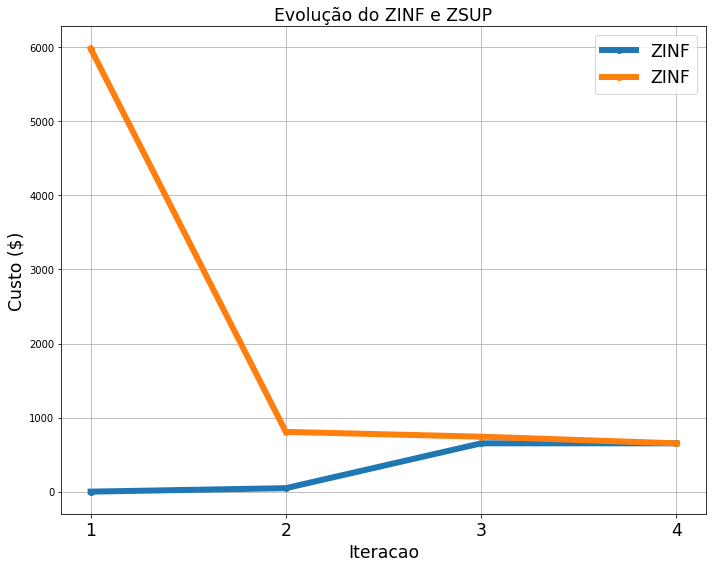

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,resultado_pddd["DGer"]["Nr_Iteracoes"]+1,1)
plt.figure(figsize=(10,8))

plt.plot(x+1, resultado_pddd["DGer"]["ZINF"] , marker='o', linewidth=6.0, label="ZINF")  
plt.plot(x+1, resultado_pddd["DGer"]["ZSUP"] , marker='o', linewidth=6.0, label="ZINF")  

plt.legend(fontsize="xx-large")   
plt.title('Evolução do ZINF e ZSUP',fontsize="xx-large")
plt.xlabel('Iteracao',fontsize="xx-large")
plt.ylabel('Custo ($)',fontsize="xx-large")
plt.xticks(x+1,fontsize="xx-large")
plt.grid()
plt.tight_layout()
plt.show()


## Plota Gráfico das UHEs

Volume Final

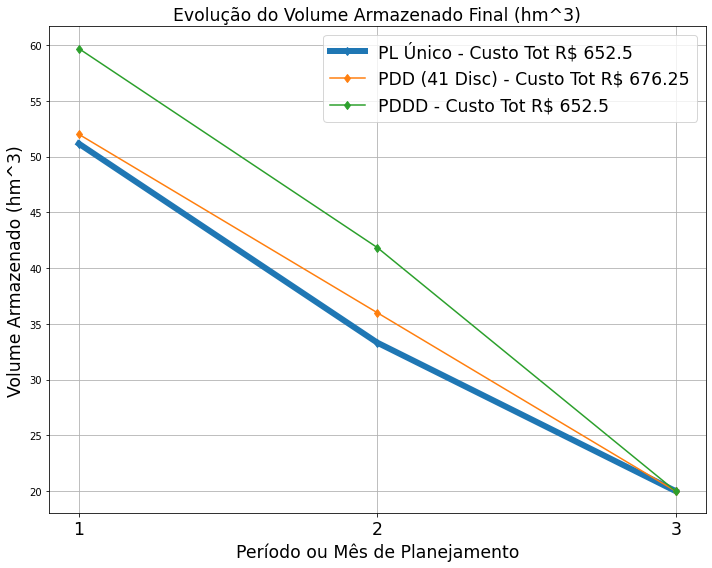

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado_plu["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d', linewidth=6.0, label="PL Único - Custo Tot R$ "+str(round(resultado_plu["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pdd41["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d', label="PDD (41 Disc) - Custo Tot R$ "+str(round(resultado_pdd41["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pddd["UHE"]):
  plt.plot(x+1, iusi['vf'] , marker='d', label="PDDD - Custo Tot R$ "+str(round(resultado_pddd["DGer"]["CustoTotal"],2)))  


plt.legend(fontsize="xx-large")   
plt.title('Evolução do Volume Armazenado Final (hm^3)',fontsize="xx-large")
plt.xlabel('Período ou Mês de Planejamento',fontsize="xx-large")
plt.ylabel('Volume Armazenado (hm^3)',fontsize="xx-large")
plt.xticks(x+1,fontsize="xx-large")
plt.grid()
plt.tight_layout()
plt.show()

## Plota Gráfico da Geração das UTEs

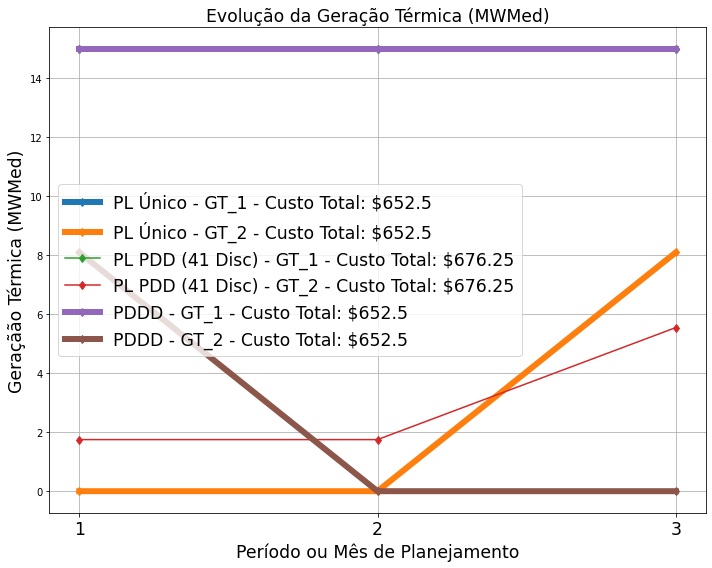

In [0]:
x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado_plu["UTE"]):
  plt.plot(x+1, iusi['gt'] , marker='d', linewidth=6.0, label="PL Único - "+sistema["UTE"][i]["Nome"]+" - Custo Total: $"+str(round(resultado_plu["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pdd41["UTE"]):
  plt.plot(x+1, iusi['gt'] , marker='d', label="PL PDD (41 Disc) - "+sistema["UTE"][i]["Nome"]+" - Custo Total: $"+str(round(resultado_pdd41["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pddd["UTE"]):
  plt.plot(x+1, iusi['gt'] , marker='d', linewidth=6.0, label="PDDD - "+sistema["UTE"][i]["Nome"]+" - Custo Total: $"+str(round(resultado_pddd["DGer"]["CustoTotal"],2)))  

plt.legend(fontsize="xx-large")   
plt.title('Evolução da Geração Térmica (MWMed)',fontsize="xx-large")
plt.xlabel('Período ou Mês de Planejamento',fontsize="xx-large")
plt.ylabel('Geraçãão Térmica (MWMed)',fontsize="xx-large")
plt.xticks(x+1,fontsize="xx-large")
plt.grid()
plt.tight_layout()
plt.show()

## Plota Gráfico das UHEs

Volume Turbinado

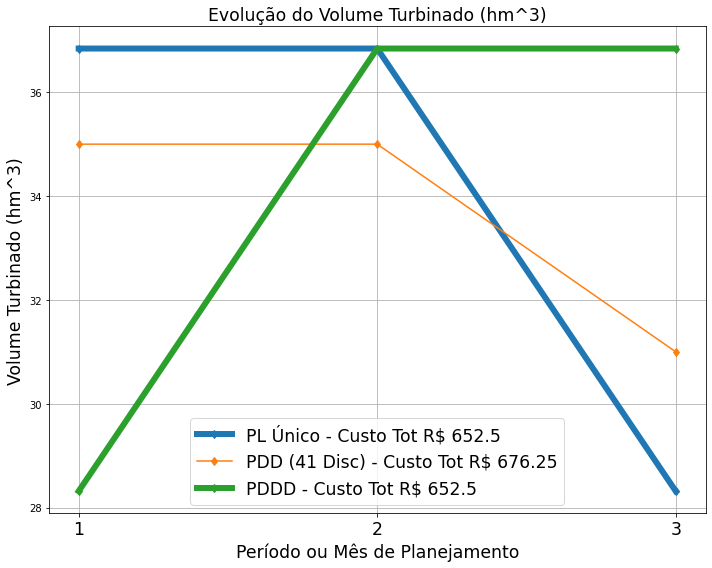

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado_plu["UHE"]):
  plt.plot(x+1, iusi['vt'] , marker='d', linewidth=6.0, label="PL Único - Custo Tot R$ "+str(round(resultado_plu["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pdd41["UHE"]):
  plt.plot(x+1, iusi['vt'] , marker='d', label="PDD (41 Disc) - Custo Tot R$ "+str(round(resultado_pdd41["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pddd["UHE"]):
  plt.plot(x+1, iusi['vt'] , marker='d', linewidth=6.0, label="PDDD - Custo Tot R$ "+str(round(resultado_pddd["DGer"]["CustoTotal"],2)))  

plt.legend(fontsize="xx-large")   
plt.title('Evolução do Volume Turbinado (hm^3)',fontsize="xx-large")
plt.xlabel('Período ou Mês de Planejamento',fontsize="xx-large")
plt.ylabel('Volume Turbinado (hm^3)',fontsize="xx-large")
plt.xticks(x+1,fontsize="xx-large")
plt.grid()
plt.tight_layout()
plt.show()

## Plota Gráfico das UHEs

Volume Vertido

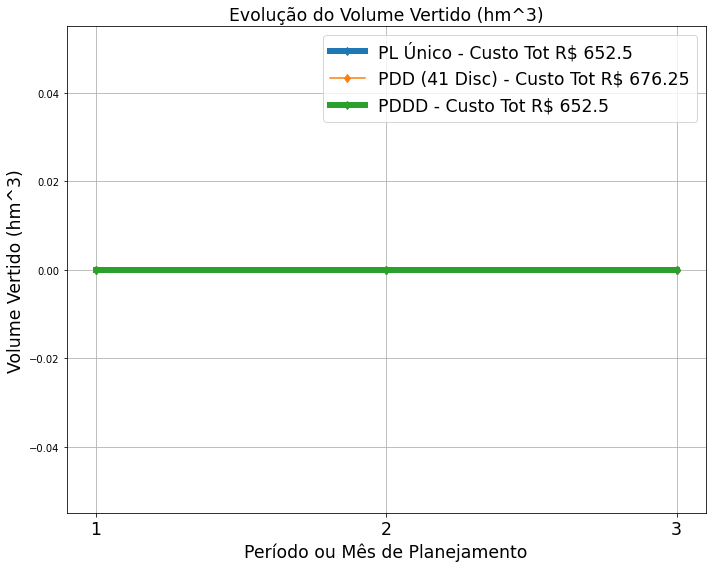

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,sistema['DGer']['Nr_Est'],1)
plt.figure(figsize=(10,8))

for i, iusi in enumerate(resultado_plu["UHE"]):
  plt.plot(x+1, iusi['vv'] , marker='d', linewidth=6.0, label="PL Único - Custo Tot R$ "+str(round(resultado_plu["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pdd41["UHE"]):
  plt.plot(x+1, iusi['vv'] , marker='d', label="PDD (41 Disc) - Custo Tot R$ "+str(round(resultado_pdd41["DGer"]["CustoTotal"],2)))  

for i, iusi in enumerate(resultado_pddd["UHE"]):
  plt.plot(x+1, iusi['vv'] , marker='d', linewidth=6.0, label="PDDD - Custo Tot R$ "+str(round(resultado_pddd["DGer"]["CustoTotal"],2)))  


plt.legend(fontsize="xx-large")   
plt.title('Evolução do Volume Vertido (hm^3)',fontsize="xx-large")
plt.xlabel('Período ou Mês de Planejamento',fontsize="xx-large")
plt.ylabel('Volume Vertido (hm^3)',fontsize="xx-large")
plt.xticks(x+1,fontsize="xx-large")
plt.grid()
plt.tight_layout()
plt.show()